Librerias

In [1]:
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from fractions import Fraction

Primera Entrega - Proyecto MRI

In [2]:
data_dir = 'MRIsamples/'
data_dir_save = data_dir + 'analyze_to_nii/'
data_ext = ['.img', '.hdr', '.nii']
filenames = ['4_8', '8_4', '100_23', '205_3', '2_4']

In [ ]:
for filename in filenames:
    try:
        #Se carga la imagen MRI simple en formato ANALYZE
        path = data_dir + filename
        img = nb.load(path + data_ext[0])
        hdr = nb.load(path + data_ext[1])

        #Se muestra la información del encabezado
        print(f"Archivo: '{filename}'")
        print(hdr.header)
        print('*********************************************************************')
        
        #Se convierte el formato de ANALYZE a NIFTI
        nii = nb.nifti1.Nifti1Image(img.get_fdata(), 
                                    hdr.affine, 
                                    hdr.header)

        #Se guarda la imagen MRI simple en formato NIFTI
        path = path.replace(data_dir, data_dir_save) + data_ext[2]
        nb.save(nii, path)
    except FileNotFoundError:
        print(f"No se pudo cargar el archivo: '{filename}'")
        print('*********************************************************************')
    except AttributeError:
        print(f"El archivo: '{filename}', se encuentra vacio")
        print('*********************************************************************')

Segunda Entrega - Proyecto MRI

In [3]:
path = data_dir_save + 'filename' + data_ext[2]

#Se cargan las imagenes en formato NIFTI
#img_4_8 = nb.load(path.replace('filename', filenames[0]))
img_8_4 = nb.load(path.replace('filename', filenames[1]))
#img_100_23 = nb.load(path.replace('filename', filenames[2]))
#img_205_3 = nb.load(path.replace('filename', filenames[3]))
#img_2_4 = nb.load(path.replace('filename', filenames[4]))

#se extrae un corte de la imagen sagital
#img1 = img_4_8.get_fdata()
#img1 = img1[150,:,:][:,:,0]
#img1 = img1[0:58,92:210]

#se extrae un corte de la imagen coronal 
img2 = img_8_4.get_fdata()
img2 = img2[:,20,:][:,:,0]
img2 = img2[72:193,76:191]

#se extrae un corte de la imagen axial 
#img3 = img_100_23.get_fdata()
#img3 = img3[:, : ,157][:,:,0]
#img3 = img3[58:196, 0:55]

#se extrae un corte de la imagen axial 
#img4 = img_2_4.get_fdata()
#img4 = img4[:, : ,162][:,:,0]
#img4 = img4[74:188, 8:62]

#print(img4.shape)
#plt.imshow(img4.T, origin='lower', cmap='gray')
#plt.show()

Difusión Anisotrópica - Explicita

In [5]:
def convolution(img, kernel):
    convolvedImg = np.zeros((img.shape[0], img.shape[1]))
    v = int(kernel.shape[0] / 2)
    
    for j in range(convolvedImg.shape[0]):
        for i in range(convolvedImg.shape[1]):
            mat = mask(img, j, i, v)
            res = np.sum(np.multiply(mat, kernel))
            convolvedImg[j, i] = res
    
    return convolvedImg

In [6]:
def mask(img, j, i, v):
    n = 2 * v + 1
    mat = np.full((n, n), -1)
    
    jmin = (j - v, 0)[(j - v) < 0]
    jmax = (jmin + n, jmin + (n - 1))[(j + v) == img.shape[0] or (j - v) < 0]
    
    imin = (i - v, 0)[(i - v) < 0]
    imax = (imin + n, imin + (n - 1))[(i + v) == img.shape[1] or (i - v) < 0]
    
    f = (0, 1)[(j - v) < 0]
    c1 = (0, 1)[(i - v) < 0]
    
    for j in range(jmin, jmax):
        c = c1
        
        for i in range(imin, imax):
            mat[f, c] = img[j, i]
            c += 1
            
        f += 1
            
    return mat

In [7]:
def anisotropic_diffusion(img, c):
    scale = Fraction(c) * Fraction(1, 4)
    
    k = np.zeros((3, 3))
    k[0, 1] = 1
    k[1, 0] = 1
    k[1, 2] = 1
    k[2, 1] = 1

    img_f = convolution(img.copy(), k)
    img_f = np.multiply(img_f, float(scale))
    
    return img_f

Difusión Anisotrópica - Implícita

In [4]:
def create_A_x_b(img, c):
    m = img.shape[0] * img.shape[1]
    scale = Fraction(c) * Fraction(1, 4)
    A = np.identity(m)
    x = np.array([img.flatten()]).T
    b = np.zeros((m , 1))
    i = 1
    
    for f in range(m - 1):
        c1 = f + 1
        c2 = f + img.shape[1]
        
        if i < img.shape[1]:
            A[f, c1] = -scale
            A[c1, f] = -scale
            
            if c2 < m:
                A[f, c2] = -scale
                A[c2, f] = -scale
                
            i += 1
        else:
            A[f, c2] = -scale
            A[c2, f] = -scale
            i = 1
    
    return A,x,b

In [5]:
def general_method(A, x, b, Q, maxit):
    I = np.identity(A.shape[0])
    Q_inv = np.linalg.inv(Q)

    new_A = I - np.dot(Q_inv, A)
    new_b = np.dot(Q_inv, b)

    x_k_anterior = x
    i = 0

    while i < maxit:
        x = np.dot(new_A, x_k_anterior) + new_b        
        x_k_anterior = x
        i = i + 1

    return x

In [6]:
def jacobi_method(A, x, b, maxit):
        
    Q = np.zeros((A.shape[0], A.shape[1]))
        
    for i in range(Q.shape[0]):
        Q[i,i] = A[i,i]
    
    return general_method(A, x, b, Q, maxit)

In [7]:
def gaussseidel_method(A, x, b, maxit):
        
    Q_tri_inf = np.tril(A, 0)
     
    return general_method(A, x, b, Q_tri_inf, maxit)

In [8]:
def x_to_img(img, x):
    i = j = 0
    
    img1 = np.zeros((img.shape[0], img.shape[1]))
    
    for f in range(x.shape[0]):
        img1[j, i] = x[f, 0]
        i = i + 1
        
        if i == img.shape[1]:
            i = 0
            j = j + 1
    
    return img1

Resultados

In [13]:
def difussionAnisotropica():
    x = anisotropic_diffusion(img2, 1)
    for i in range(1,10):
        x = anisotropic_diffusion(x, 1)
    return x

Tercera Entrega - Proyecto MRI

In [10]:
def newtonRaphson(img, lineal_method, maxiter_nr, maxiter_lm, c):
    A, x0, b = create_A_x_b(img, c)
    x_k_anterior = x0 
    x0_l_m = np.zeros(x0.shape)
    i = 0
    data = None
    while i < maxiter_nr:
        x0_l_m = x_k_anterior + x0_l_m
        data = lineal_method(A, x0_l_m, b, maxiter_lm)
        x = x_k_anterior - data
        x_k_anterior = x
        i += 1 
    return x_k_anterior

In [13]:
A_lm, x0_lm, b_lm = create_A_x_b(img2, 0.1)

In [14]:
# Metodo de jacobi
image_jc = jacobi_method(A_lm, x0_lm, b_lm, 100)

In [15]:
# Metodo de gauss seidel
image_gs = jacobi_method(A_lm, x0_lm, b_lm, 100)

In [16]:
# Netwon Raphson evaluado en metodo de jacobi
image_nr_jc = newtonRaphson(img2, jacobi_method, 30, 100, 0.1)

In [17]:
# Netwon Raphson evaluado en metodo de gauss seidel
image_nr_gs = newtonRaphson(img2, gaussseidel_method, 30, 100, 0.1)

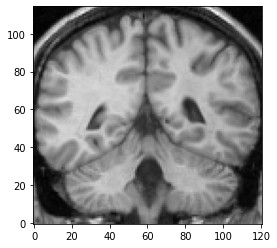

In [54]:
# Imagen corte original
plt.imshow(img2.T, origin = 'lower', cmap = 'gray')
plt.savefig('Results/Corte/img_8_4.png')
plt.show()

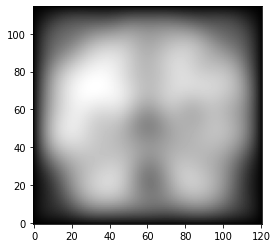

In [45]:
# Imagen resultante jacobi
plt.imshow(x_to_img(img2, image_jc).T, origin = 'lower', cmap = 'gray')
plt.savefig('Results/Jacobi/img_8_4_jc_i100_c01.png')
plt.show()


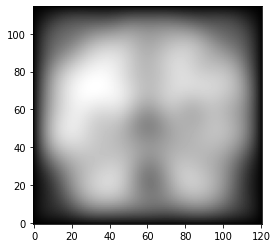

In [46]:
# Imagen resultante gauss seidel
plt.imshow(x_to_img(img2, image_gs).T, origin = 'lower', cmap = 'gray')
plt.savefig('Results/Gauss Seidel/img_8_4_gs_i100_c01.png')
plt.show()


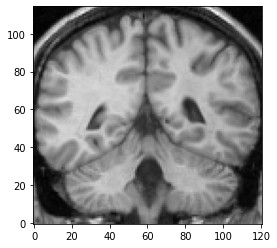

In [48]:
# Imagen resultante newton raphson con jacobi
plt.imshow(x_to_img(img2, image_nr_jc).T, origin = 'lower', cmap = 'gray')
plt.savefig('Results/Newton Raphson/Jacobi/img_8_4_nr_i30_jc_i100_c01.png')
plt.show()

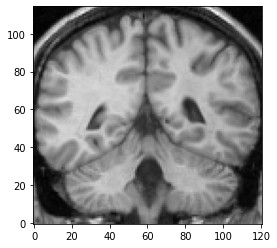

In [47]:
# Imagen resultante newton raphson con gauss seidel
plt.imshow(x_to_img(img2, image_nr_gs).T, origin = 'lower', cmap = 'gray')
plt.savefig('Results/Newton Raphson/Gauss Seidel/img_8_4_nr_i30_gs_i100_c01.png')
plt.show()

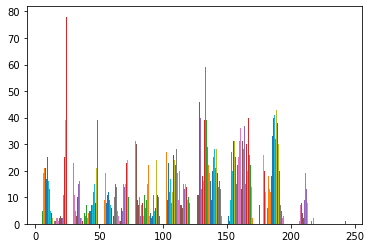

In [53]:
# Histograma imagen original
plt.hist(img2)
plt.savefig('Results/Corte/hist_img_8_4.png')
plt.show()

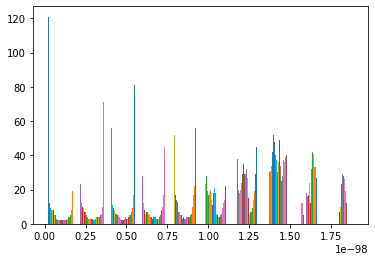

In [49]:
# Histograma jacobi
plt.hist(x_to_img(img2, image_jc))
plt.savefig('Results/Jacobi/hist_img_8_4_jc_i100_c01.png')
plt.show()

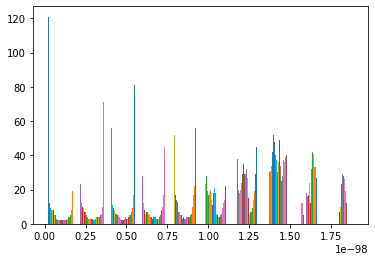

In [50]:
# Histograma gauss seidel
plt.hist(x_to_img(img2, image_gs))
plt.savefig('Results/Gauss Seidel/hist_img_8_4_gs_i100_c01.png')
plt.show()

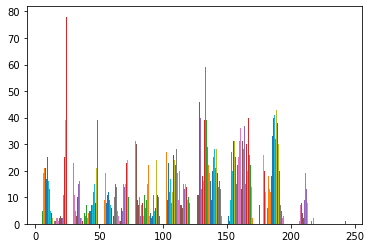

In [51]:
# Histograma newton raphson con jacobi
plt.hist(x_to_img(img2, image_nr_jc))
plt.savefig('Results/Newton Raphson/Jacobi/hist_img_8_4_nr_i30_jc_i100_c01.png')
plt.show()

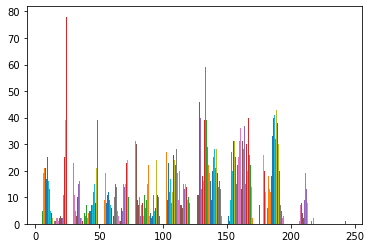

In [52]:
# Histograma newton raphson con gauss seidel
plt.hist(x_to_img(img2, image_nr_gs))
plt.savefig('Results/Newton Raphson/Gauss Seidel/hist_img_8_4_nr_i30_gs_i100_c01.png')
plt.show()